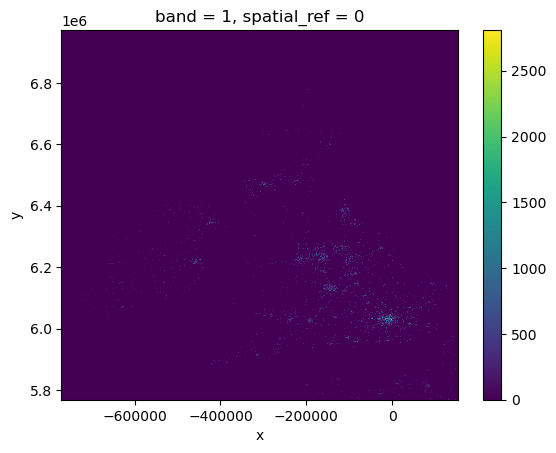

In [29]:
import xarray as xr
import rasterio as rio
import rioxarray
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import pandas as pd
import geopandas as gpd

def load_raster(path):
    with rio.open(path) as file:
        raster_data = file.read()
        transform = file.transform
        crs = file.crs
        raster_data = xr.DataArray(raster_data).squeeze()
        # Add crs and transform as metadata
        raster_data.attrs['transform'] = transform
        raster_data.attrs['crs'] = crs
    
        
    return raster_data


path_electricity = "data/annual-heat-electricity-demand-twh.csv"
path_populations = "build/population-europe.tif"
path_spatial_units_national = "data/units_national.geojson"

spatial_units_national = gpd.read_file(path_spatial_units_national).set_index("id")

# populations = load_raster(path_populations)
populations = rioxarray.open_rasterio(path_populations).squeeze()
populations.plot()


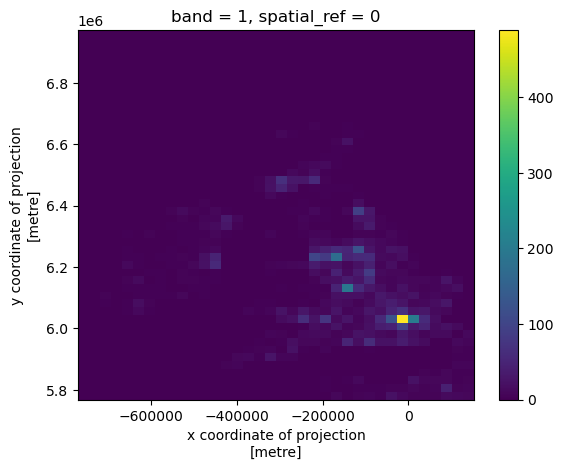

In [25]:
from rasterio.enums import Resampling
populations_coarse = populations.rio.reproject(populations.rio.crs, shape=tuple(int(i*0.01) for i in populations.shape), resampling=Resampling.average)
populations_coarse.plot()

In [121]:
electricity = pd.read_csv(path_electricity, index_col=[0,1,2,3])
electricity = pd.merge(electricity, spatial_units_national, left_on="country_code", right_on="id")
electricity = gpd.GeoDataFrame(electricity, geometry="geometry").to_crs(populations.rio.crs)

<GeoAxes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

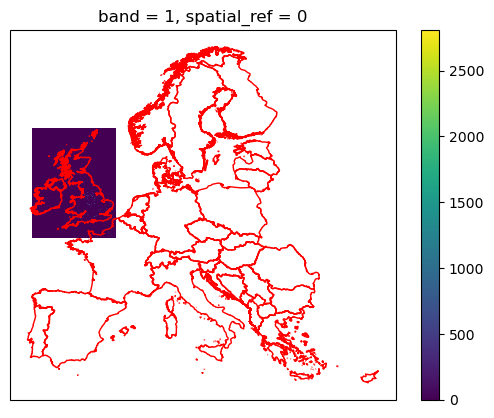

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.Mollweide())
populations.plot.imshow(ax=ax)
spatial_units_national.to_crs(populations.rio.crs).plot(ax=ax, facecolor="none", edgecolor="red")

In [20]:
spatial_units_uk = spatial_units_national.loc[spatial_units_national["country_code"] == "GBR"]
spatial_units_uk

,country_code,name,type,proper,geometry
id,,,,,
GBR,GBR,United Kingdom,country,True,"MULTIPOLYGON (((-3.34384 58.64666, -3.29351 58..."


In [21]:
from rasterio.features import geometry_mask
import numpy as np


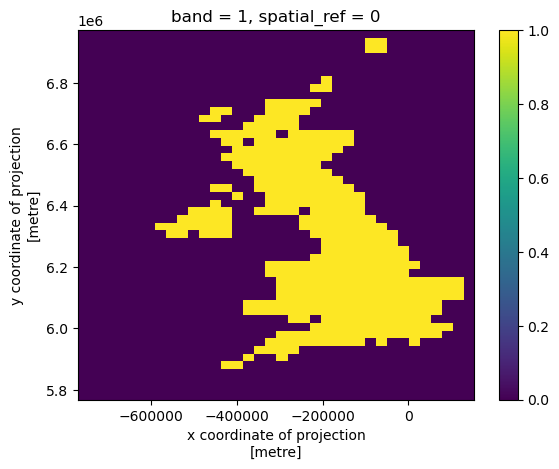

In [27]:
raster_data = populations_coarse
vector_data = spatial_units_uk.to_crs(raster_data.rio.crs)

assert raster_data.rio.crs == vector_data.crs, f"crs of raster data {raster_data.rio.crs} does not match crs of spatial units {vector_data.crs}"

geometry = vector_data.geometry.values[0]

mask = geometry_mask([geometry], out_shape=raster_data.shape, transform=raster_data.rio.transform(), invert=True)

mask = xr.DataArray(mask, coords=raster_data.coords, dims=raster_data.dims)
mask.plot.imshow()

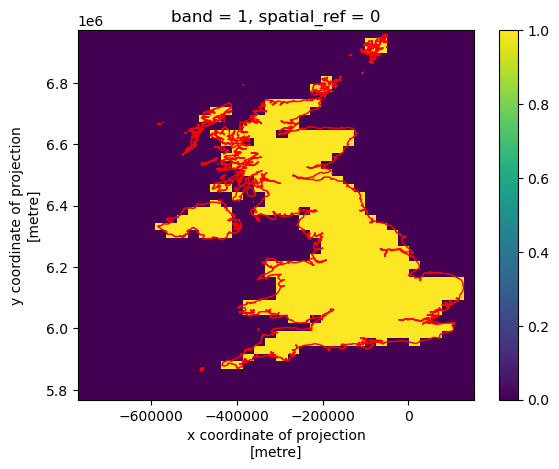

In [28]:
fig, ax = plt.subplots()
gpd.GeoDataFrame(data=None, geometry=[geometry]).plot(ax=ax, facecolor="none", edgecolor="red")
mask.plot.imshow(ax=ax)